In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/raw/clients.csv")

In [2]:
FEATURES = [
    "age",
    "income",
    "credit_amount",
    "loan_duration",
    "employment_years"
]

X = df[FEATURES]
X_norm = (X - X.mean()) / X.std()

df["risk_score"] = (
    0.4 * X_norm["credit_amount"]
    + 0.3 * X_norm["loan_duration"]
    - 0.5 * X_norm["income"]
    - 0.4 * X_norm["employment_years"]
)


In [3]:
def acceptance_rate(df, col):
    return df[col].mean()

def dp_gap(df, col):
    acc = df.groupby("sex")[col].mean()
    return abs(acc[0] - acc[1])

In [4]:
threshold = df["risk_score"].quantile(0.6)
df["accepted_baseline"] = (df["risk_score"] <= threshold).astype(int)

baseline_perf = acceptance_rate(df, "accepted_baseline")
baseline_dp = dp_gap(df, "accepted_baseline")

baseline_perf, baseline_dp

(np.float64(0.6), np.float64(0.8571428571428572))

In [5]:
epsilons = np.linspace(0.0, 0.5, 11)
performances = []
fairness = []

for EPS in epsilons:
    best_acceptance = 0

    scores_f = df[df["sex"] == 0]["risk_score"]
    scores_m = df[df["sex"] == 1]["risk_score"]

    for q_f in np.linspace(0.2, 0.9, 20):
        for q_m in np.linspace(0.2, 0.9, 20):

            t_f = scores_f.quantile(q_f)
            t_m = scores_m.quantile(q_m)

            df["accepted_tmp"] = 0
            df.loc[(df["sex"] == 0) & (df["risk_score"] <= t_f), "accepted_tmp"] = 1
            df.loc[(df["sex"] == 1) & (df["risk_score"] <= t_m), "accepted_tmp"] = 1

            gap = dp_gap(df, "accepted_tmp")

            if gap <= EPS:
                acc = acceptance_rate(df, "accepted_tmp")
                best_acceptance = max(best_acceptance, acc)

    performances.append(best_acceptance)
    fairness.append(EPS)


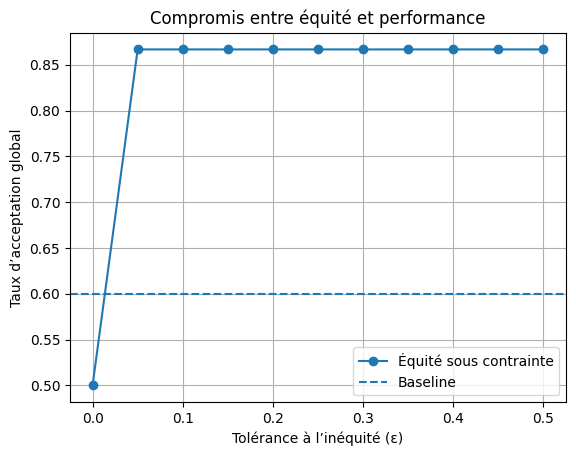

In [6]:
plt.plot(fairness, performances, marker="o", label="Équité sous contrainte")
plt.axhline(baseline_perf, linestyle="--", label="Baseline")
plt.xlabel("Tolérance à l’inéquité (ε)")
plt.ylabel("Taux d’acceptation global")
plt.title("Compromis entre équité et performance")
plt.legend()
plt.grid(True)
plt.show()


Cette analyse met en évidence un compromis clair entre équité et performance.
Plus la contrainte d’équité est stricte (ε faible), plus le taux d’acceptation
global diminue.

À l’inverse, relâcher la contrainte d’équité permet d’améliorer la performance,
au prix d’une augmentation des disparités entre groupes.

Ce résultat illustre le coût mesurable de l’équité dans les systèmes de décision
automatisés et justifie l’utilisation d’optimisations sous contraintes en finance.
